In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

HTML_IMG_SIZE = {'x':285.0, 'y':435.0}
GROUP1_TRIANGLES = json.load(open('../images/image_params_group1.json','r'))
GROUP2_TRIANGLES = json.load(open('../images/image_params_group2.json','r'))
PRACTICE_TRIANGLE = json.load(open('../images/image_params_practice.json','r'))

### Extract columns, organize data, and append triangle params to data

In [2]:
def extract_cols(data):
    data = data[['WorkerId', 'Answer.group', 
             'Answer.pracX', 'Answer.pracY', 'Answer.pracRT', 
             'Answer.trialIndex', 'Answer.trialImg',
             'Answer.taskX', 'Answer.taskY', 'Answer.taskRT']]
    data = data.rename(columns={'Answer.group': 'group', 
                            'Answer.pracX': 'pracX',
                            'Answer.pracY': 'pracY',
                            'Answer.pracRT': 'pracRT',
                            'Answer.trialIndex': 'trialIndex',
                            'Answer.trialImg': 'trialImg',
                            'Answer.taskX': 'taskX',
                            'Answer.taskY': 'taskY',
                            'Answer.taskRT': 'taskRT'})
    return data

def split_values(string, token=','):
    values = string.split(token)[1:] # first value is a leading placeholder
    return np.array([int(x) for x in values])

def organize_data_subject(data, subject):
    trialIndex = split_values(data['trialIndex'][0])
    trialImg = split_values(data['trialImg'][0])
    taskX = split_values(data['taskX'][0])
    taskY = split_values(data['taskY'][0])
    taskRT = split_values(data['taskRT'][0])
    
    # practice trial
    subject_data = [[subject, data['group'].values[0], 'practice', 'practice', 
                     data['pracX'].values[0], data['pracY'].values[0], data['pracRT'].values[0]]]
    # task trials
    for i in trialIndex:
        subject_data.append([subject, data['group'].values[0], trialIndex[i], trialImg[i],
                              taskX[i], taskY[i], taskRT[i]])
        
    subject_data = pd.DataFrame(subject_data,
                                columns=['subject', 'group', 'trial', 'img', 'estX', 'estY', 'rt'],
                                dtype=np.int64)

    return subject_data
        
def organize_data(data):
    subjects = np.unique(data['WorkerId'])
    new_data = [organize_data_subject(data[data['WorkerId']==s], i) for (i,s) in enumerate(subjects)]
    new_data = pd.concat(new_data)
    return new_data

def add_scaledXY(data):
    # append to data in place
    # convert click coordinates into triangle coords ([0,1])
    scaledX = data['estX'].values / HTML_IMG_SIZE['x']
    scaledY = data['estY'].values / HTML_IMG_SIZE['y']
    scaledY = 1 - scaledY # note that the mouse click coordinate in js is relative to the top of the image container
    data['scaledX'] = scaledX
    data['scaledY'] = scaledY

def add_triangle_params(data):
    # add triangle params for each (group, image)
    # column order: baseAngle, baseLen, sideLen, height, leftX, leftY, rightX, rightY, topX, topY
    column_names = ['baseAngle', 'baseLen', 'sideLen', 'height', 
                    'leftX', 'leftY', 'rightX', 'rightY', 'topX', 'topY']
    triangle_params = []
    
    for i in range(len(data)):
        
        row = data.iloc[i]
        group = row['group']
        img = row['img']
        config = None
        if (img == 'practice'):
            config = PRACTICE_TRIANGLE
        elif (group==1):
            config = GROUP1_TRIANGLES[str(img)] # image number is a str dict key
        elif (group==2):
            config = GROUP2_TRIANGLES[str(img)]
        else:
            print("This shouldn't happen...")
        
        triangle_params.append([config['base_angle'], config['base_len'], 
                                config['side_len'], config['height'],
                                config['L_coord'][0], config['L_coord'][1],
                                config['R_coord'][0], config['R_coord'][1],
                                config['T_coord'][0], config['T_coord'][1]])
        
    triangle_params = pd.DataFrame(triangle_params, columns=column_names, dtype=np.int64)
    return data.join(triangle_params)

In [3]:
data = pd.read_csv('../data/test_batch_results.csv') # read batch data
new_data = organize_data(extract_cols(data.copy())) # extract columns
add_scaledXY(new_data) # add scaled (x,y) click
new_data = add_triangle_params(new_data) # add true triangle params

In [4]:
new_data.head()

,subject,group,trial,img,estX,estY,rt,scaledX,scaledY,baseAngle,baseLen,sideLen,height,leftX,leftY,rightX,rightY,topX,topY
0,0,2,practice,practice,50,435,2317,0.175439,0.000000,56,0.66,0.590136,0.489245,0.170,0,0.830,0,0.5,0.489245
1,0,2,0,2,126,435,1385,0.442105,0.000000,66,0.10,0.122930,0.112302,0.450,0,0.550,0,0.5,0.112302
2,0,2,1,13,1,434,1398,0.003509,0.002299,51,1.00,0.794508,0.617449,0.000,0,1.000,0,0.5,0.617449
3,0,2,2,5,107,436,1316,0.375439,-0.002299,66,0.25,0.307324,0.280755,0.375,0,0.625,0,0.5,0.280755
4,0,2,3,14,1,435,1150,0.003509,0.000000,66,1.00,1.229297,1.123018,0.000,0,1.000,0,0.5,1.123018


### Sanity Check
<p> The test batch results are from a turk sandbox test where I intentially clicked the left vertex of the triangle.

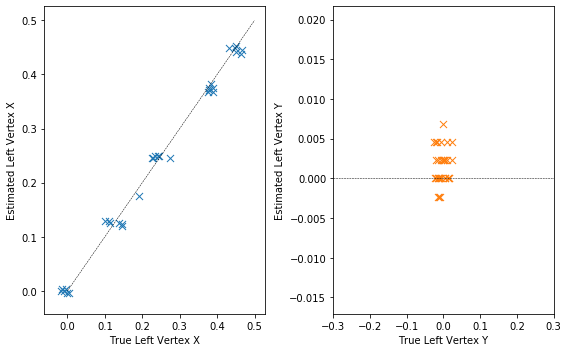

In [5]:
fig, axes = plt.subplots(1,2,figsize=[8,5])

# add some jitter to x axis
x = new_data['leftX'].copy()
x += (np.random.rand(len(x))-0.5)/20 # add some jitter
y = new_data['scaledX']
axes[0].scatter(x, y, c='C0', lw=1, marker='x', s=50)
axes[0].plot([0,0.5],[0,0.5], '--k', lw=0.5)

x = new_data['leftY'].copy()
x += (np.random.rand(len(x))-0.5)/20 # add some jitter
y = new_data['scaledY']
axes[1].scatter(x, y, c='C1', lw=1, marker='x', s=50)
axes[1].axhline(0, ls='--', c='k', lw=0.5)

axes[1].set_xlim([-0.3, 0.3])
axes[0].set_xlabel('True Left Vertex X')
axes[0].set_ylabel('Estimated Left Vertex X')
axes[1].set_xlabel('True Left Vertex Y')
axes[1].set_ylabel('Estimated Left Vertex Y')

fig.tight_layout()
fig.savefig('plot/sanity_check.pdf')